## **0. Imports**

In [7]:
# necessary to import data
import gzip
import struct
import os

# storing data
import numpy as np

# plotting
import matplotlib.pyplot as plt

## **1. Data Acquisition and Visualization**

In [8]:
# given function to read data in from a gzip file and return a np array
def read_gzip_file(filename):
    with gzip.open(filename, 'rb') as f:
      zero, data_type, dims = struct.unpack('>HBB', f.read(4))
      shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
      return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [10]:
# let's use the above function to pull in all of our data and take a look the shapes of it
test_images = read_gzip_file('t10k-images-idx3-ubyte.gz')
test_labels = read_gzip_file('t10k-labels-idx1-ubyte.gz')
train_images = read_gzip_file('train-images-idx3-ubyte.gz')
train_labels = read_gzip_file('train-labels-idx1-ubyte.gz')

# print out the shapes of our above created datasets
print(f'Training Images: {train_images.shape} and Training Labels: {train_labels.shape}')
print(f'Testing Images: {test_images.shape} and Testing Labels: {test_labels.shape}')

FileNotFoundError: [Errno 2] No such file or directory: 't10k-images-idx3-ubyte.gz'

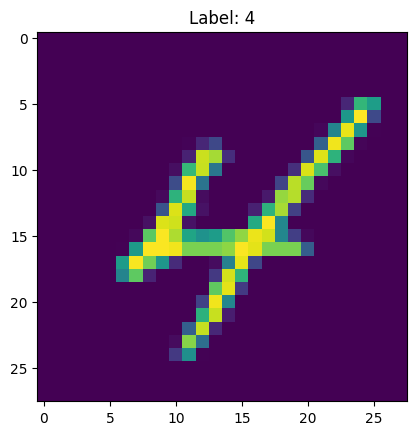

In [5]:
# select a random data index in the training set
random_index = np.random.randint(0, train_images.shape[0])

# store the data point and label at the random index
image, label = train_images[random_index], train_labels[random_index]

# visualize the data point along with the label
plt.title(f'Label: {label}')
plt.imshow(image)
plt.show()

## **2. Data Preprocessing**

In [6]:
# normalize the pixel-values of images so that all values are between 0 and 1
train_images_norm = train_images.copy() / 255.0
test_images_norm = test_images.copy() / 255.0

# convert the labels from categorical data into numerical values using one-hot encoding
# store the number of classes = 10 (0-9)
num_classes = 10

# create an identity matrix of size = num_classes
one_hot_matrix = np.eye(num_classes)

# create a new matrix to store the one-hot encoded labels
encoded_train_labels = np.array([one_hot_matrix[label] for label in train_labels])
encoded_test_labels = np.array([one_hot_matrix[label] for label in test_labels])

encoded_train_labels.shape

(60000, 10)

## **3. Network Initialization**

In [7]:
# Resize the images to be 2D
train_images_norm = train_images_norm.copy().reshape((60000, 28*28))
test_images = test_images.copy().reshape(10000, 28*28)

In [8]:
# define the sigmoid function - activation function for hidden layers
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [9]:
# define the derivative of the sigmoid function
def sigmoid_derivative(x):
  return sigmoid(x) * (1 - sigmoid(x))

In [10]:
# define the soft-max function - activation function for output layers
def soft_max(x):
  e_x = np.exp(x)
  return e_x/e_x.sum(axis=1, keepdims=True)

In [11]:
# define network architecture
input_size, output_size = 784, 10
hidden1_size, hidden2_size = 128, 64

# Set the random seed
seed_value = 695
np.random.seed(seed_value)

# establish weights and biases for input layer
W1 = np.random.uniform(-0.1, 0.1, size=(input_size, hidden1_size))
b1 = np.zeros((1, hidden1_size))

# establish weights and biases for hidden layer 1
W2 = np.random.uniform(-0.1, 0.1, size=(hidden1_size, hidden2_size))
b2 = np.zeros((1, hidden2_size))

# establish weights and biases for hidden layer 2
W3 = np.random.uniform(-0.1, 0.1, size=(hidden2_size, output_size))
b3 = np.zeros((1, output_size))

## **4. Feed Forward**

In [12]:
# params: x - a data point; w - a weight value; b - a bias values
def feed_forward(x, W1, b1, W2, b2, W3, b3):

  z1 = np.dot(x, W1) + b1
  a1 = sigmoid(z1)

  z2 = np.dot(a1, W2) + b2
  a2 = sigmoid(z2)

  z3 = np.dot(a2, W3) + b3
  a3 = soft_max(z3)

  return a1, a2, a3

## **5. Back Propagation**

In [13]:
# function to calculate the categorical cross-entropy
def categorical_cross_entropy_loss(y_true, y_pred):
  # store the number of samples
  n_samples = y_true.shape[0]

  # ensure that the y_pred data is within a certain range
  y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)

  # return the categorical cross entropy
  return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples

In [14]:
# function to carry out back propagation
def backpropagation(x, y_true, W1, W2, W3, a1, a2, a3):

  dz3 = a3 - y_true
  dW3 = np.dot(a2.T, dz3)
  db3 = np.sum(dz3, axis=0, keepdims=True)

  dz2 = dz3.dot(W3.T) * sigmoid_derivative(a2)
  dW2 = np.dot(a1.T, dz2)
  db2 = np.sum(dz2, axis=0, keepdims=True)

  dz1 = dz2.dot(W2.T) * sigmoid_derivative(a1)
  dW1 = np.dot(x.T, dz1)
  db1 = np.sum(dz1, axis=0, keepdims=True)

  return dW1, db1, dW2, db2, dW3, db3

## **6. Model Training**

In [ ]:
# define parameters of our mini-batch gradient descent
batch_size = 128
epoch_count = 100
alpha = 0.1

In [ ]:
# use mini-batch gradient descent to update the parameters including weights and biases
def mini_batch_gradient_descent(epochs, batch_size, alpha, X, y, W1, b1, W2, b2, W3, b3):
  # declare a variable to store theta and cost at each computed value of theta
  J_history = []

  # iterate the specified number of times
  for epoch in range(epochs):
    indices = np.arange(train_images_norm.shape[0])
    np.random.shuffle(indices)
    n_batches = int(train_images_norm.shape[0]/batch_size)

    for batch in range(n_batches):
        batch_indices = indices[batch * batch_size: (batch+1)*batch_size]
        batch_X, batch_Y = X[batch_indices], y[batch_indices]

        # feed forward
        a1, a2, a3 = feed_forward(batch_X, W1, b1, W2, b2, W3, b3)

        # back propagations
        dW1, db1, dW2, db2, dW3, db3 = backpropagation(batch_X, batch_Y, W1, W2, W3, a1, a2, a3)

        # Update weights
        W1 -= alpha * dW1
        b1 -= alpha * db1
        W2 -= alpha * dW2
        b2 -= alpha * db2
        W3 -= alpha * dW3
        b3 -= alpha * db3


    # rerun feed forward to make predictions
    a1, a2, a3 = feed_forward(X, W1, b1, W2, b2, W3, b3)

    # compute and store the cost
    loss = categorical_cross_entropy_loss(y, a3)
    J_history.append(loss)

  # return theta and cost_history
  return W1, b1, W2, b2, W3, b3, J_history

In [ ]:
W1, b1, W2, b2, W3, b3, J_history = mini_batch_gradient_descent(epoch_count, batch_size, 0.01, train_images_norm, encoded_train_labels, W1, b1, W2, b2, W3, b3)

<ipython-input-196-9e3bacca1f85>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## **7. Model Evaluation**

In [ ]:
# use feed forward to return an array of probability predictions
a1, a2, a3 = feed_forward(test_images, W1, b1, W2, b2, W3, b3)

# convert the probabilities into predictions
predictions = np.argmax(a3, axis=1)

# count the number of correct predictions
correct = np.sum(predictions == test_labels)

# calculate the accuracy of our model
accuracy = correct / test_labels.shape[0]
print(f'Accuracy: {accuracy * 100}%')

Accuracy: 80.97%


<ipython-input-196-9e3bacca1f85>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [ ]:
# store 5 of the incorrectly classified imagegs
incorrect_images = []

for i, image in enumerate(test_images):
  if predictions[i] != test_labels[i]:
    incorrect_images.append([image, test_labels[i], predictions[i]])

print(f'Incorrectly Classified Count: {len(incorrect_images)}')

Incorrectly Classified Count: 1903


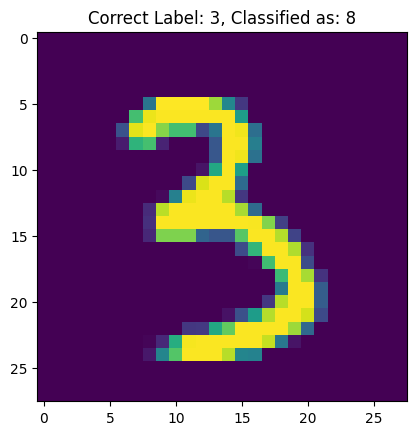

In [ ]:
# Change this variable to any number in the range (0, Incorrectly Classified Count)
idx = 2

image, label, prediction = incorrect_images[4]

plt.title(f'Correct Label: {label}, Classified as: {prediction}')
plt.imshow(image.reshape(28,28))
plt.show()